In [1]:
import pandas as pd
import git
import mlflow.keras
import pandas as pd
import os
import numpy as np
from gensim.models.wrappers import FastText

import tensorflow_hub as hub
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import *

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
path = '/home/joshib/cs_data/citation-bio-labelled-data-2020-06-08~15:13:57.766608/nlp/exps/output/2020-06-08~15:13:57.766608'
#data_df = pd.read_csv(path+'/data-2020-06-08~15:14:01.185827.csv')

## LSTM with random embedding model

In [4]:
%%time
#train_data_path = '/home/joshib/cs_data/citation-bio-labelled-data-2020-06-09~06:30:11.273245/nlp/exps/output/2020-06-09~06:30:11.273245'
#train_data_path = '/nlp/cs_data/2020-06-09~06:30:11.273245'
train_data_path = '/nlp/cs_data_full/cs_data_train/'
test_data_path  = '/nlp/cs_data_full/cs_data_test/'

pattern = "*#*#"
sentences = []
sent_tags = []
len_arr = []
for fpath in os.listdir(train_data_path):
    if fpath not in ['data-gen-config.json', 'data_generation_stats.csv'] and ".csv" in fpath:
        fpath = os.path.join(train_data_path, fpath)
        df = pd.read_csv(fpath, index_col=0)
        df.fillna("\n", axis=1, inplace=True)
        len_arr.append(df.shape[0])
        sentences.append(pattern.join(df.x))
        sent_tags.append(pattern.join(df.y))
        
sentences_test = []
sent_tags_test = []
for fpath in os.listdir(test_data_path):
    if fpath not in ['data-gen-config.json', 'data_generation_stats.csv'] and ".csv" in fpath:
        fpath = os.path.join(test_data_path, fpath)
        df = pd.read_csv(fpath, index_col=0)
        df.fillna("\n", axis=1, inplace=True)
        len_arr.append(df.shape[0])
        sentences_test.append(pattern.join(df.x))
        sent_tags_test.append(pattern.join(df.y))

CPU times: user 2min 45s, sys: 3.4 s, total: 2min 49s
Wall time: 3min 24s


In [5]:
import numpy
print("Min: %d"%numpy.min(len_arr))
print("Max: %d"%numpy.max(len_arr))
print("Mean: %d"%numpy.mean(len_arr))
print("Median: %d"%numpy.median(len_arr))

Min: 26
Max: 7272
Mean: 1602
Median: 1543


In [6]:
%%time
### Train
maxlen = max(len_arr)
X = [[w for w in s.split(pattern)] for s in sentences]
y = [[p for p in t.split(pattern)] for t in sent_tags]

new_X = []
new_y = []
for ind in range(len(X)):
    new_seq = []
    new_tag = []
    for i in range(maxlen):
        try:
            new_seq.append(X[ind][i])
            new_tag.append(y[ind][i])
        except:
            new_seq.append("PADword")
            new_tag.append("I-CIT")
    new_X.append(new_seq)
    new_y.append(new_tag)

### Test
X_test = [[w for w in s.split(pattern)] for s in sentences_test]
y_test = [[p for p in t.split(pattern)] for t in sent_tags_test]

new_X_test = []
new_y_test = []
for ind in range(len(X_test)):
    new_seq = []
    new_tag = []
    for i in range(maxlen):
        try:
            new_seq.append(X_test[ind][i])
            new_tag.append(y_test[ind][i])
        except:
            new_seq.append("PADword")
            new_tag.append("I-CIT")
    new_X_test.append(new_seq)
    new_y_test.append(new_tag)

CPU times: user 3min 11s, sys: 5.4 s, total: 3min 16s
Wall time: 3min 16s


In [7]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
#maxlen = 1000 # max number of words in a question to use

In [8]:
%%time
tags = df.y.unique()
tags2index = {'B-CIT': 1, 'I-CIT': 0}
new_y_enc = np.array([[tags2index[w] for w in s] for s in new_y])
new_y_test_enc = np.array([[tags2index[w] for w in s] for s in new_y_test])
#y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tags2index["I-CIT"])

CPU times: user 43.4 s, sys: 1.45 s, total: 44.8 s
Wall time: 44.8 s


In [9]:
X_train_orig, X_valid_orig, y_train, y_valid = train_test_split(new_X, new_y_enc, test_size=0.1, random_state=42)

tokenizer = Tokenizer(num_words=max_features, oov_token=1)
tokenizer.fit_on_texts(list(X_train_orig))
X_train  = np.array(tokenizer.texts_to_sequences(X_train_orig))
X_valid  = np.array(tokenizer.texts_to_sequences(X_valid_orig))
X_test   = np.array(tokenizer.texts_to_sequences(new_X_test))

In [10]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(28011, 7272)
(3113, 7272)
(7778, 7272)


## Keras with pre-trained fast text embedding

In [11]:
%%time
wiki_model = FastText.load_fasttext_format('/nlp/cc.en.300.bin')

CPU times: user 3min, sys: 4.27 s, total: 3min 4s
Wall time: 3min 25s


In [12]:
%%time
def load_embedding_matrix(embeddings, nb_words, word_index, embed_dim):  # load embeddings
    embeddings_index = {}
    for word in embeddings.wv.vocab:
        embeddings_index[word] = embeddings[word]
    print('Found %s word vectors.' % len(embeddings_index))

    words_not_found = []
    embedding_matrix = np.zeros((nb_words, embed_dim))
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = embeddings[word]
            embedding_matrix[i] = embedding_vector
        except:
            words_not_found.append(word)
    print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix


embedding_matrix = load_embedding_matrix(wiki_model, max_features, tokenizer.word_index, 300)

Found 2000000 word vectors.
number of null word embeddings: 10209
CPU times: user 7.91 s, sys: 236 ms, total: 8.14 s
Wall time: 8.14 s


In [13]:
#np.save('embedding_matrix.npy', embedding_matrix)
#embedding_matrix = np.load('./embedding_matrix.npy')

In [14]:
%%time
model = Sequential()
model.add(Embedding(max_features, 300, weights=[embedding_matrix], trainable=True, input_length= maxlen))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(1, activation="sigmoid")))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=Adam(
        learning_rate=0.001,
        beta_1=0.0,
        beta_2=0.0,
        epsilon=1e-05,
        amsgrad=False,
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:820: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (isinstance(inputs, collections.Sequence)
/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7272, 300)         30000000  
_________________________________________________________________
lstm (LSTM)                  (None, 7272, 50)          70200     
_________________________________________________________________
time_distributed (TimeDistri (None, 7272, 1)           51        
Total params: 30,070,251
Trainable params: 30,070,251
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.49 s, sys: 947 ms, total: 2.44 s
Wall time: 5.07 s


In [15]:
def calulate_ser_jer(y_true, y_pred):
    """
    :param y_true:
    :param y_pred:
    :param keep_tag:
    :return:
    """
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    ser = 1.0
    if (tp + fp) > 0.0:
        ser = fp / float(tp + fp)
    jer = 1.0
    if (tp + fn) > 0.0:
        jer = fn / float(tp + fn)
    return ser, jer

class Metrics(callbacks.Callback):
    def __init__(self, train_data, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_train_begin(self, logs={}):
        self.val_ser = []
        self.val_jer = []
        
    def on_epoch_end(self, epoch, logs):
        vx = self.validation_data[0]
        vy = self.validation_data[1]
        vx = np.array(vx)
        pred_y = None
        pred_y = self.model.predict(vx)
        py = np.argmax(pred_y, axis=-1)
        #vy = np.argmax(vy, axis=-1)
        vy = np.array(vy).flatten()
        py = np.array(py).flatten()
        ser, jer = calulate_ser_jer(vy, py)
        print(ser, jer)
        self.val_ser.append(ser)
        self.val_jer.append(jer)
        logs["val_ser"] = ser
        logs["val_jer"] = jer
        print(f"— val_ser: {ser} — val_jer: {jer}")

#         gold_x, gold_y, x = df_to_input()
#         pred_y = self.model.predict(x)
#         py = np.argmax(pred_y, axis=-1)[0]
#         gy = np.argmax(gold_y, axis=-1)
#         data = []
#         for i in range(len(gold_x)):
#             data.append({"x": gold_x[i], "gold": gy[i], "pred": py[i]})
#         d = pd.DataFrame(data)
#         d.to_csv("./" + str(epoch) + ".predictions.on.sample.csv")
        return 

In [16]:
metrics = Metrics([X_train, y_train], [X_valid, y_valid])

Epoch 1/200


/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/training/tracking/data_structures.py:718: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


438/438 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.99611.0 1.0
— val_ser: 1.0 — val_jer: 1.0
438/438 [==============================] - 380s 867ms/step - loss: 0.0210 - accuracy: 0.9961 - val_loss: 4.4917e-04 - val_accuracy: 0.9999 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 2/200
438/438 [==============================] - ETA: 0s - loss: 1.6263e-04 - accuracy: 1.00001.0 1.0
— val_ser: 1.0 — val_jer: 1.0
438/438 [==============================] - 378s 864ms/step - loss: 1.6263e-04 - accuracy: 1.0000 - val_loss: 8.1088e-05 - val_accuracy: 1.0000 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 3/200
438/438 [==============================] - ETA: 0s - loss: 5.2871e-05 - accuracy: 1.00001.0 1.0
— val_ser: 1.0 — val_jer: 1.0
438/438 [==============================] - 378s 863ms/step - loss: 5.2871e-05 - accuracy: 1.0000 - val_loss: 3.9356e-05 - val_accuracy: 1.0000 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 4/200
438/438 [==============================] - ETA: 0s - loss

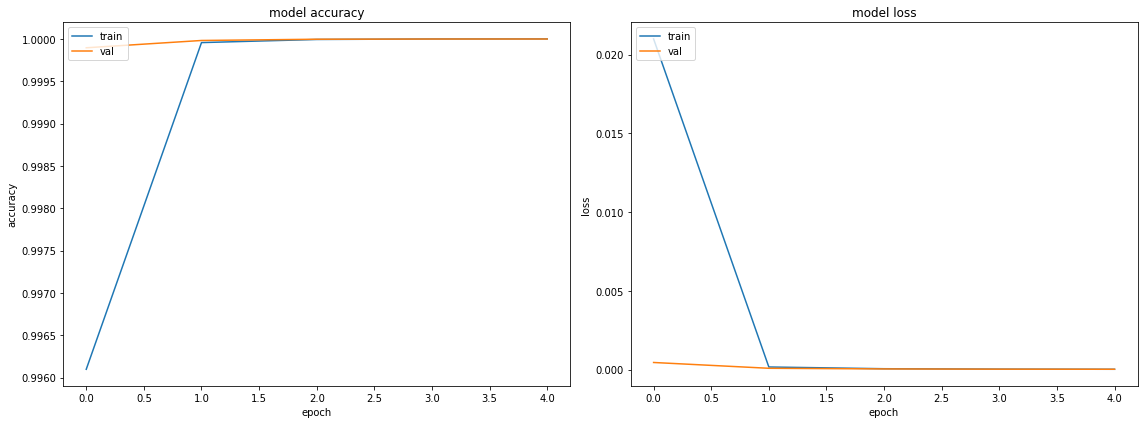

In [17]:
%%time
early_stop= EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min',restore_best_weights=False, min_delta=0.0001)
history = model.fit(X_train, y_train, verbose=1, epochs=200, batch_size= 64, validation_data=(X_valid, y_valid), callbacks=[early_stop,metrics])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].title.set_text('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].title.set_text('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')
fig.tight_layout()

### Analysis on validation data

In [18]:
valid_probs = model.predict(X_valid)
valid_probs = valid_probs.reshape(valid_probs.shape[0], valid_probs.shape[1])
valid_preds = np.where(valid_probs > 0.5, 1, 0)

In [19]:
ser_jer = [calulate_ser_jer(i,j) for i,j in zip(y_valid, valid_preds)]
accuracy = [accuracy_score(i,j) for i,j in zip(y_valid, valid_preds)]

In [20]:
print("Mean SER: %0.6f"%np.mean([i[0] for i in ser_jer]))
print("Mean JER: %0.6f"%np.mean([i[1] for i in ser_jer]))
print("Mean Accuracy: %0.6f"%np.mean(accuracy))

Mean SER: 0.000111
Mean JER: 0.000101
Mean Accuracy: 0.999999


In [30]:
count_valid = 0
for ind in range(len(valid_preds)):
    pred = valid_preds[ind]
    true = y_valid[ind]
    if (true == pred).all():
        pass
    else:
        count_valid += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(fp_ind)
            print(ind, 'False positives:', fp_ind)
            for x in fp_ind:
                #print(x)
                print(np.array(X_valid_orig[ind])[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                print(np.array(X_valid_orig[ind])[max(0, x-3):x+4])

195 False positives: [1]
['K.W.' 'Roth,' 'D.' 'Westphalen,' 'P.']
308 False positives: [664]
['\n' '\n' '\n' 'Conaire,' 'M.,' 'Curran,' 'H.J.,']
308 False negatives: [663]
['\n' '\n' '\n' '\n' 'Conaire,' 'M.,' 'Curran,']
311 False positives: [396 401]
['\n' '\n' '\n' '(2017).' '\n' '\n' '\n']
['\n' '\n' '\n' '(2010)' 'V21(7):1644–1646.' '\n' '\n']
311 False negatives: [395 400]
['\n' '\n' '\n' '\n' '(2017).' '\n' '\n']
['\n' '\n' '\n' '\n' '(2010)' 'V21(7):1644–1646.' '\n']
341 False positives: [71]
['\n' '\n' '\n' 'Conaire,' 'M.,' 'Curran,' 'H.J.,']
341 False negatives: [70]
['\n' '\n' '\n' '\n' 'Conaire,' 'M.,' 'Curran,']
429 False negatives: [0]
['Chia,' 'S.R.,' 'Ong,' 'H.C.,']
521 False positives: [2]
['Zaja' '\n' 'c' 'M,' 'Doradzinski' 'R,']
942 False positives: [236 241]
['\n' '\n' '\n' '(2017).' '\n' '\n' '\n']
['\n' '\n' '\n' '(2010)' 'V21(7):1644–1646.' '\n' '\n']
942 False negatives: [235 240]
['\n' '\n' '\n' '\n' '(2017).' '\n' '\n']
['\n' '\n' '\n' '\n' '(2010)' 'V21(7):164

In [22]:
# for ind in range(5):
#     print(ind, np.array(X_valid_orig)[ind][np.where(y_valid[ind] == 1)])

In [23]:
print("%d mistakes out of total %d citations"%(count_valid, len(valid_preds)))

21 mistakes out of total 3113 citations


### Analysis of test result

In [31]:
test_probs = model.predict(X_test)
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[1])
test_preds = np.where(test_probs > 0.5, 1, 0)

In [32]:
ser_jer = [calulate_ser_jer(i,j) for i,j in zip(new_y_test_enc, test_preds)]
accuracy = [accuracy_score(i,j) for i,j in zip(new_y_test_enc, test_preds)]

In [33]:
print("Mean SER: %0.6f"%np.mean([i[0] for i in ser_jer]))
print("Mean JER: %0.6f"%np.mean([i[1] for i in ser_jer]))
print("Mean Accuracy: %0.6f"%np.mean(accuracy))

Mean SER: 0.000098
Mean JER: 0.000059
Mean Accuracy: 0.999999


In [36]:
count = 0
for ind in range(len(test_preds)):
    pred = test_preds[ind]
    true = new_y_test_enc[ind]
    if (true == pred).all():
        pass
    else:
        count += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(fp_ind)
            print(ind, 'False positives:', fp_ind)
            for x in fp_ind:
                #print(x)
                print(np.array(new_X_test[ind])[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                print(np.array(new_X_test[ind])[max(0, x-3):x+4])

14 False positives: [2]
['O’' '\n' 'Connor,' 'P.,' 'A' 'general']
64 False positives: [253]
['\n' '\n' '\n'
 'mamatsu.com.cn/UserFiles/DownFile/Product/MCPassy_TMCP0001E1012345pdf\n'
 '(accessed' '05.05.2017).' '\n']
117 False negatives: [0]
['Health' 'MDo.' 'MIIC' 'and']
305 False positives: [1241]
['\n' '\n' '\n' 'G.V.' 'Samsonov,' 'The' 'oxide']
305 False negatives: [1240]
['\n' '\n' '\n' '\n' 'G.V.' 'Samsonov,' 'The']
401 False negatives: [0]
['Glanz,' 'Karen,' 'Barbara' 'K.']
774 False negatives: [0]
['Energy' 'efficient' '&' 'Cost']
976 False negatives: [0]
['Energy' 'Research' 'Institute' 'of']
990 False negatives: [0]
['Health' 'MDo.' 'MIIC' 'and']
1353 False positives: [1175]
['\n' '\n' '\n' 'Nanofiltration—An' 'Overview' 'of' 'Technology']
1353 False negatives: [1174]
['\n' '\n' '\n' '\n' 'Nanofiltration—An' 'Overview' 'of']
1723 False negatives: [0]
['Research' 'Group' 'in' 'Earthquake,']
1932 False positives: [2]
['Bundesamt' '\n' 'für' 'Statistik,' 'Statistisches' 'Lexikon

In [28]:
# for ind in range(5):
#     print(ind, np.array(new_X_test)[ind][np.where(new_y_test_enc[ind] == 1)])

In [35]:
print("%d mistakes out of total %d citations"%(count, len(test_preds)))

51 mistakes out of total 7778 citations


In [41]:
new_X_test[64]

['Massey,',
 'R.,',
 '&',
 'Ulmer,',
 'A.',
 '(2010).',
 'Agriculture',
 'and',
 'greenhouse',
 'gas',
 'emissions.',
 'University',
 'of',
 'Missouri',
 'Extension.',
 'http://extension.missouri.edu/p',
 'G,',
 '310.',
 '\n',
 '\n',
 '\n',
 'Kota',
 'A',
 'K,',
 'Kwon',
 'G,',
 'Choi',
 'W,',
 'et',
 'al.',
 'Hygro-responsive',
 'membranes',
 'for',
 'effective',
 'oil–water',
 'separation[J].',
 'Nature',
 'communications,',
 '2012,',
 '3:',
 '1025.',
 '\n',
 '\n',
 '\n',
 'Yu',
 'Y,',
 'Chen',
 'H,',
 'Liu',
 'Y,',
 'et',
 'al.',
 'Superhydrophobic',
 'and',
 'Superoleophilic',
 'Boron',
 'Nitride',
 'Nanotube‐Coated',
 'Stainless',
 'Steel',
 'Meshes',
 'for',
 'Oil',
 'and',
 'Water',
 'Separation[J].',
 'Advanced',
 'Materials',
 'Interfaces,',
 '2014,',
 '1(1).',
 '\n',
 '\n',
 '\n',
 '{Li,',
 '2016',
 '#37}(20)',
 'Huang',
 'J',
 'Y,',
 'Lai',
 'Y',
 'K,',
 'Pan',
 'F,',
 'et',
 'al.',
 'Multifunctional',
 'superamphiphobic',
 'TiO2',
 'nanostructure',
 'surfaces',
 'with',
 'f

### Keras with random embedding

In [25]:
# %%time
# model = Sequential()
# model.add(Embedding(max_features, embed_size, input_length=maxlen))
# model.add(Bidirectional(LSTM(512, return_sequences=True)))
# #model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(TimeDistributed(Dense(1, activation="sigmoid")))
# # # model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(
#         learning_rate=0.005,
#         beta_1=0.0,
#         beta_2=0.0,
#         epsilon=1e-05,
#         amsgrad=False,
#     ),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [26]:
#model.fit(X_train, y_train, verbose=1, epochs=5, validation_data=(X_test, y_test))

### Code check

In [35]:
# import pandas as pd
# import numpy as np
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import *
# import tensorflow as tf

# X = np.random.randint(1000, size=(10000, 80))
# y = np.random.choice([0,1], size=10000)

# model = Sequential()
# model.add(Embedding(1000, 50, input_length = 80))
# model.add(LSTM(10))
# model.add(Dense(1, activation='sigmoid'))
# print ('Compiling...')
# model.compile(loss='binary_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])
# print(model.summary())

In [214]:
#wiki_model['[']

In [42]:
temp_x = new_X_test[0:5]
temp_y = new_y_test_enc[0:5]

In [43]:
stops = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [44]:
temp_x_new = []
for sent in temp_x:
    sent_new = []
    for word in sent:
        if word == '\n':
            random.shuffle(stops)
            sent_new.append(stops[0])
        else:
            sent_new.append(word)
    temp_x_new.append(sent_new)

In [45]:
X_test_temp = np.array(tokenizer.texts_to_sequences(temp_x_new))

In [46]:
temp_probs = model.predict(X_test_temp)
temp_probs = temp_probs.reshape(temp_probs.shape[0], temp_probs.shape[1])
temp_preds = np.where(temp_probs > 0.5, 1, 0)

In [47]:
ser_jer = [calulate_ser_jer(i,j) for i,j in zip(temp_y, temp_preds)]
accuracy = [accuracy_score(i,j) for i,j in zip(temp_y, temp_preds)]

In [48]:
print("Mean SER: %0.6f"%np.mean([i[0] for i in ser_jer]))
print("Mean JER: %0.6f"%np.mean([i[1] for i in ser_jer]))
print("Mean Accuracy: %0.6f"%np.mean(accuracy))

Mean SER: 0.000000
Mean JER: 0.983388
Mean Accuracy: 0.991474


In [49]:
for ind in range(5):
    pred = temp_preds[ind]
    true = temp_y[ind]
    print(ind, len(np.where(pred == 1)[0]), len(np.where(true == 1)[0]), len(np.where((pred == 1) & (true == 0))[0]), len(np.where((pred == 0) & (true == 1))[0]))

0 1 47 0 46
1 1 65 0 64
2 1 79 0 78
3 1 75 0 74
4 1 49 0 48


In [50]:
len(np.where(temp_preds[0] ==1)[0])

1

In [51]:
#temp_x_new[0]

In [52]:
np.where(temp_y[0] == 1)

(array([   0,   47,   69,   88,  119,  134,  154,  191,  220,  270,  290,
         313,  343,  366,  391,  448,  485,  529,  569,  588,  621,  650,
         684,  717,  739,  767,  801,  832,  857,  883,  906,  937,  968,
        1004, 1038, 1069, 1116, 1155, 1186, 1237, 1275, 1320, 1348, 1388,
        1424, 1467, 1495]),)

In [53]:
np.where(temp_preds[0] == 1)

(array([0]),)

In [269]:
bla = temp_preds[0]

In [272]:
np.where(bla == 1)[0]

array([0])

In [18]:
print('testy')

testy
